In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import random
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F
import math
import time

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def no_of_params(model):
    sum_ = 0.
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float32)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = Y[1][0]/3.1415926
            Y = Y - 0.5
            
            Y = torch.tensor( Y, dtype=torch.float32 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y
    
all_ids = [str(i) for i in  list(np.arange(0,10000,1))]
#train_ids = all_ids[:8000]
#val_ids   = all_ids[8000:]#1000]

train_ids = all_ids[:800]
val_ids   = all_ids[800:1000]#1000]

params = {
    'batch_size'  : 8,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

In [75]:
def train_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [76]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1  = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=1)
        self.bn1    = nn.BatchNorm2d(8)
        self.conv2  = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.bn2    = nn.BatchNorm2d(16)
        self.pool   = nn.MaxPool2d(2,2)
        self.conv4  = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.bn4    = nn.BatchNorm2d(32)
        self.conv5  = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.bn5    = nn.BatchNorm2d(64)
        self.fc1    = nn.Linear(64*10*10, 1)

    def forward(self, input):
        output = torch.tanh(self.bn1(self.conv1(input)))      
        output = torch.tanh(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = torch.tanh(self.bn4(self.conv4(output)))     
        output = torch.tanh(self.bn5(self.conv5(output))) 
        #print(output.shape)
        output = output.view(-1, 64*10*10)
        output = self.fc1(output)
        output = torch.tanh(output)

        return output

In [65]:
model = Network()
no_of_params(model)

74405

In [93]:
lr = 1e-7
wd = 1e-3
model = Network()

epochs = 3000
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd,
    )

# scheduler = lr_scheduler.CyclicLR(
#     optimizer,
#     base_lr=1e-8,
#     max_lr=1e-7,
#     cycle_momentum=False,
#     gamma=1,
#     step_size_up=10,
#     step_size_down =10,
#     mode='triangular2',
#)

gamma = 0.998
scheduler = lr_scheduler.ExponentialLR(
    optimizer, 
    #step_size = scheduler_step_size, 
    gamma     = gamma)

train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    #optimizer.step()
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

# txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
# plt.title(txt)
# plt.plot(train_losses)
# plt.plot(val_losses)
# plt.show()

# for batch in validation_generator:
#     break
# output = model(batch[0])
# output
# plt.title(txt)
# plt.plot(output.detach().numpy()*3.1415926)
# plt.plot(batch[1].detach().numpy()*3.1415926)
# plt.show()

EPOCH:  1  Train loss:  0.0892  Val loss:  0.0736  LR:  9.98e-08
EPOCH:  2  Train loss:  0.0732  Val loss:  0.0602  LR:  9.96e-08
EPOCH:  3  Train loss:  0.0573  Val loss:  0.0476  LR:  9.94e-08
EPOCH:  4  Train loss:  0.0451  Val loss:  0.0392  LR:  9.92e-08
EPOCH:  5  Train loss:  0.0361  Val loss:  0.032  LR:  9.9e-08
EPOCH:  6  Train loss:  0.0288  Val loss:  0.0274  LR:  9.88e-08
EPOCH:  7  Train loss:  0.0239  Val loss:  0.0234  LR:  9.86e-08
EPOCH:  8  Train loss:  0.021  Val loss:  0.0214  LR:  9.84e-08
EPOCH:  9  Train loss:  0.018  Val loss:  0.0194  LR:  9.82e-08
EPOCH:  10  Train loss:  0.0162  Val loss:  0.0179  LR:  9.8e-08
EPOCH:  11  Train loss:  0.0158  Val loss:  0.0176  LR:  9.78e-08
EPOCH:  12  Train loss:  0.0152  Val loss:  0.0167  LR:  9.76e-08
EPOCH:  13  Train loss:  0.0149  Val loss:  0.0174  LR:  9.74e-08
EPOCH:  14  Train loss:  0.0154  Val loss:  0.0174  LR:  9.72e-08
EPOCH:  15  Train loss:  0.0161  Val loss:  0.0189  LR:  9.7e-08
EPOCH:  16  Train loss:  

EPOCH:  126  Train loss:  0.0044  Val loss:  0.0061  LR:  7.77e-08
EPOCH:  127  Train loss:  0.0044  Val loss:  0.0059  LR:  7.75e-08
EPOCH:  128  Train loss:  0.0043  Val loss:  0.0058  LR:  7.74e-08
EPOCH:  129  Train loss:  0.0044  Val loss:  0.0056  LR:  7.72e-08
EPOCH:  130  Train loss:  0.0042  Val loss:  0.0054  LR:  7.71e-08
EPOCH:  131  Train loss:  0.0044  Val loss:  0.0053  LR:  7.69e-08
EPOCH:  132  Train loss:  0.0044  Val loss:  0.0051  LR:  7.68e-08
EPOCH:  133  Train loss:  0.0041  Val loss:  0.005  LR:  7.66e-08
EPOCH:  134  Train loss:  0.0042  Val loss:  0.0048  LR:  7.65e-08
EPOCH:  135  Train loss:  0.004  Val loss:  0.0045  LR:  7.63e-08
EPOCH:  136  Train loss:  0.0041  Val loss:  0.0044  LR:  7.62e-08
EPOCH:  137  Train loss:  0.004  Val loss:  0.0042  LR:  7.6e-08
EPOCH:  138  Train loss:  0.004  Val loss:  0.0042  LR:  7.59e-08
EPOCH:  139  Train loss:  0.0038  Val loss:  0.0039  LR:  7.57e-08
EPOCH:  140  Train loss:  0.0038  Val loss:  0.0038  LR:  7.56e-08


EPOCH:  249  Train loss:  0.0009  Val loss:  0.0011  LR:  6.07e-08
EPOCH:  250  Train loss:  0.001  Val loss:  0.0011  LR:  6.06e-08
EPOCH:  251  Train loss:  0.0009  Val loss:  0.0011  LR:  6.05e-08
EPOCH:  252  Train loss:  0.001  Val loss:  0.0011  LR:  6.04e-08
EPOCH:  253  Train loss:  0.0009  Val loss:  0.0011  LR:  6.03e-08
EPOCH:  254  Train loss:  0.0009  Val loss:  0.0011  LR:  6.01e-08
EPOCH:  255  Train loss:  0.0009  Val loss:  0.001  LR:  6e-08
EPOCH:  256  Train loss:  0.0009  Val loss:  0.001  LR:  5.99e-08
EPOCH:  257  Train loss:  0.0009  Val loss:  0.001  LR:  5.98e-08
EPOCH:  258  Train loss:  0.0009  Val loss:  0.001  LR:  5.97e-08
EPOCH:  259  Train loss:  0.0009  Val loss:  0.001  LR:  5.95e-08
EPOCH:  260  Train loss:  0.0009  Val loss:  0.001  LR:  5.94e-08
EPOCH:  261  Train loss:  0.0009  Val loss:  0.001  LR:  5.93e-08
EPOCH:  262  Train loss:  0.0008  Val loss:  0.0009  LR:  5.92e-08
EPOCH:  263  Train loss:  0.0008  Val loss:  0.0009  LR:  5.91e-08
EPOCH: 

EPOCH:  372  Train loss:  0.0004  Val loss:  0.0004  LR:  4.75e-08
EPOCH:  373  Train loss:  0.0004  Val loss:  0.0004  LR:  4.74e-08
EPOCH:  374  Train loss:  0.0004  Val loss:  0.0004  LR:  4.73e-08
EPOCH:  375  Train loss:  0.0004  Val loss:  0.0003  LR:  4.72e-08
EPOCH:  376  Train loss:  0.0004  Val loss:  0.0003  LR:  4.71e-08
EPOCH:  377  Train loss:  0.0004  Val loss:  0.0004  LR:  4.7e-08
EPOCH:  378  Train loss:  0.0004  Val loss:  0.0004  LR:  4.69e-08
EPOCH:  379  Train loss:  0.0004  Val loss:  0.0004  LR:  4.68e-08
EPOCH:  380  Train loss:  0.0004  Val loss:  0.0004  LR:  4.67e-08
EPOCH:  381  Train loss:  0.0004  Val loss:  0.0004  LR:  4.66e-08
EPOCH:  382  Train loss:  0.0004  Val loss:  0.0003  LR:  4.65e-08
EPOCH:  383  Train loss:  0.0004  Val loss:  0.0004  LR:  4.65e-08
EPOCH:  384  Train loss:  0.0004  Val loss:  0.0003  LR:  4.64e-08
EPOCH:  385  Train loss:  0.0004  Val loss:  0.0003  LR:  4.63e-08
EPOCH:  386  Train loss:  0.0004  Val loss:  0.0003  LR:  4.62e

EPOCH:  495  Train loss:  0.0002  Val loss:  0.0002  LR:  3.71e-08
EPOCH:  496  Train loss:  0.0002  Val loss:  0.0002  LR:  3.7e-08
EPOCH:  497  Train loss:  0.0002  Val loss:  0.0002  LR:  3.7e-08
EPOCH:  498  Train loss:  0.0002  Val loss:  0.0002  LR:  3.69e-08
EPOCH:  499  Train loss:  0.0002  Val loss:  0.0002  LR:  3.68e-08
EPOCH:  500  Train loss:  0.0002  Val loss:  0.0002  LR:  3.68e-08
EPOCH:  501  Train loss:  0.0002  Val loss:  0.0002  LR:  3.67e-08
EPOCH:  502  Train loss:  0.0002  Val loss:  0.0002  LR:  3.66e-08
EPOCH:  503  Train loss:  0.0002  Val loss:  0.0002  LR:  3.65e-08
EPOCH:  504  Train loss:  0.0002  Val loss:  0.0002  LR:  3.65e-08
EPOCH:  505  Train loss:  0.0002  Val loss:  0.0002  LR:  3.64e-08
EPOCH:  506  Train loss:  0.0002  Val loss:  0.0002  LR:  3.63e-08
EPOCH:  507  Train loss:  0.0002  Val loss:  0.0002  LR:  3.62e-08
EPOCH:  508  Train loss:  0.0002  Val loss:  0.0002  LR:  3.62e-08
EPOCH:  509  Train loss:  0.0002  Val loss:  0.0002  LR:  3.61e-

EPOCH:  618  Train loss:  0.0002  Val loss:  0.0001  LR:  2.9e-08
EPOCH:  619  Train loss:  0.0001  Val loss:  0.0001  LR:  2.9e-08
EPOCH:  620  Train loss:  0.0001  Val loss:  0.0001  LR:  2.89e-08
EPOCH:  621  Train loss:  0.0002  Val loss:  0.0001  LR:  2.88e-08
EPOCH:  622  Train loss:  0.0001  Val loss:  0.0001  LR:  2.88e-08
EPOCH:  623  Train loss:  0.0001  Val loss:  0.0001  LR:  2.87e-08
EPOCH:  624  Train loss:  0.0001  Val loss:  0.0001  LR:  2.87e-08
EPOCH:  625  Train loss:  0.0001  Val loss:  0.0001  LR:  2.86e-08
EPOCH:  626  Train loss:  0.0001  Val loss:  0.0001  LR:  2.86e-08
EPOCH:  627  Train loss:  0.0001  Val loss:  0.0001  LR:  2.85e-08
EPOCH:  628  Train loss:  0.0001  Val loss:  0.0001  LR:  2.84e-08
EPOCH:  629  Train loss:  0.0001  Val loss:  0.0001  LR:  2.84e-08
EPOCH:  630  Train loss:  0.0001  Val loss:  0.0001  LR:  2.83e-08
EPOCH:  631  Train loss:  0.0001  Val loss:  0.0001  LR:  2.83e-08
EPOCH:  632  Train loss:  0.0001  Val loss:  0.0001  LR:  2.82e-

EPOCH:  741  Train loss:  0.0001  Val loss:  0.0001  LR:  2.27e-08
EPOCH:  742  Train loss:  0.0001  Val loss:  0.0001  LR:  2.26e-08
EPOCH:  743  Train loss:  0.0001  Val loss:  0.0001  LR:  2.26e-08
EPOCH:  744  Train loss:  0.0001  Val loss:  0.0001  LR:  2.25e-08
EPOCH:  745  Train loss:  0.0001  Val loss:  0.0001  LR:  2.25e-08
EPOCH:  746  Train loss:  0.0001  Val loss:  0.0001  LR:  2.25e-08
EPOCH:  747  Train loss:  0.0001  Val loss:  0.0001  LR:  2.24e-08
EPOCH:  748  Train loss:  0.0001  Val loss:  0.0001  LR:  2.24e-08
EPOCH:  749  Train loss:  0.0001  Val loss:  0.0001  LR:  2.23e-08
EPOCH:  750  Train loss:  0.0001  Val loss:  0.0001  LR:  2.23e-08
EPOCH:  751  Train loss:  0.0001  Val loss:  0.0001  LR:  2.22e-08
EPOCH:  752  Train loss:  0.0001  Val loss:  0.0001  LR:  2.22e-08
EPOCH:  753  Train loss:  0.0001  Val loss:  0.0001  LR:  2.21e-08
EPOCH:  754  Train loss:  0.0001  Val loss:  0.0001  LR:  2.21e-08
EPOCH:  755  Train loss:  0.0001  Val loss:  0.0001  LR:  2.21

EPOCH:  864  Train loss:  0.0001  Val loss:  0.0001  LR:  1.77e-08
EPOCH:  865  Train loss:  0.0001  Val loss:  0.0001  LR:  1.77e-08
EPOCH:  866  Train loss:  0.0001  Val loss:  0.0001  LR:  1.77e-08
EPOCH:  867  Train loss:  0.0001  Val loss:  0.0001  LR:  1.76e-08
EPOCH:  868  Train loss:  0.0001  Val loss:  0.0001  LR:  1.76e-08
EPOCH:  869  Train loss:  0.0001  Val loss:  0.0001  LR:  1.76e-08
EPOCH:  870  Train loss:  0.0001  Val loss:  0.0001  LR:  1.75e-08
EPOCH:  871  Train loss:  0.0001  Val loss:  0.0001  LR:  1.75e-08
EPOCH:  872  Train loss:  0.0001  Val loss:  0.0001  LR:  1.75e-08
EPOCH:  873  Train loss:  0.0001  Val loss:  0.0001  LR:  1.74e-08
EPOCH:  874  Train loss:  0.0001  Val loss:  0.0001  LR:  1.74e-08
EPOCH:  875  Train loss:  0.0001  Val loss:  0.0001  LR:  1.73e-08
EPOCH:  876  Train loss:  0.0001  Val loss:  0.0001  LR:  1.73e-08
EPOCH:  877  Train loss:  0.0001  Val loss:  0.0001  LR:  1.73e-08
EPOCH:  878  Train loss:  0.0001  Val loss:  0.0001  LR:  1.72

EPOCH:  987  Train loss:  0.0001  Val loss:  0.0001  LR:  1.39e-08
EPOCH:  988  Train loss:  0.0001  Val loss:  0.0001  LR:  1.38e-08
EPOCH:  989  Train loss:  0.0001  Val loss:  0.0001  LR:  1.38e-08
EPOCH:  990  Train loss:  0.0001  Val loss:  0.0001  LR:  1.38e-08
EPOCH:  991  Train loss:  0.0001  Val loss:  0.0001  LR:  1.38e-08
EPOCH:  992  Train loss:  0.0001  Val loss:  0.0001  LR:  1.37e-08
EPOCH:  993  Train loss:  0.0001  Val loss:  0.0001  LR:  1.37e-08
EPOCH:  994  Train loss:  0.0001  Val loss:  0.0001  LR:  1.37e-08
EPOCH:  995  Train loss:  0.0001  Val loss:  0.0001  LR:  1.36e-08
EPOCH:  996  Train loss:  0.0001  Val loss:  0.0001  LR:  1.36e-08
EPOCH:  997  Train loss:  0.0001  Val loss:  0.0001  LR:  1.36e-08
EPOCH:  998  Train loss:  0.0001  Val loss:  0.0001  LR:  1.36e-08
EPOCH:  999  Train loss:  0.0001  Val loss:  0.0001  LR:  1.35e-08
EPOCH:  1000  Train loss:  0.0001  Val loss:  0.0001  LR:  1.35e-08
EPOCH:  1001  Train loss:  0.0001  Val loss:  0.0001  LR:  1.

EPOCH:  1108  Train loss:  0.0001  Val loss:  0.0001  LR:  1.09e-08
EPOCH:  1109  Train loss:  0.0001  Val loss:  0.0001  LR:  1.09e-08
EPOCH:  1110  Train loss:  0.0001  Val loss:  0.0001  LR:  1.08e-08
EPOCH:  1111  Train loss:  0.0001  Val loss:  0.0001  LR:  1.08e-08
EPOCH:  1112  Train loss:  0.0001  Val loss:  0.0001  LR:  1.08e-08
EPOCH:  1113  Train loss:  0.0001  Val loss:  0.0001  LR:  1.08e-08
EPOCH:  1114  Train loss:  0.0001  Val loss:  0.0001  LR:  1.08e-08
EPOCH:  1115  Train loss:  0.0001  Val loss:  0.0001  LR:  1.07e-08
EPOCH:  1116  Train loss:  0.0001  Val loss:  0.0001  LR:  1.07e-08
EPOCH:  1117  Train loss:  0.0001  Val loss:  0.0001  LR:  1.07e-08
EPOCH:  1118  Train loss:  0.0001  Val loss:  0.0001  LR:  1.07e-08
EPOCH:  1119  Train loss:  0.0001  Val loss:  0.0001  LR:  1.06e-08
EPOCH:  1120  Train loss:  0.0001  Val loss:  0.0001  LR:  1.06e-08
EPOCH:  1121  Train loss:  0.0001  Val loss:  0.0001  LR:  1.06e-08
EPOCH:  1122  Train loss:  0.0001  Val loss:  0.

EPOCH:  1232  Train loss:  0.0001  Val loss:  0.0  LR:  8.5e-09
EPOCH:  1233  Train loss:  0.0001  Val loss:  0.0  LR:  8.5e-09
EPOCH:  1234  Train loss:  0.0001  Val loss:  0.0001  LR:  8.5e-09
EPOCH:  1235  Train loss:  0.0001  Val loss:  0.0  LR:  8.4e-09
EPOCH:  1236  Train loss:  0.0001  Val loss:  0.0  LR:  8.4e-09
EPOCH:  1237  Train loss:  0.0001  Val loss:  0.0  LR:  8.4e-09
EPOCH:  1238  Train loss:  0.0001  Val loss:  0.0  LR:  8.4e-09
EPOCH:  1239  Train loss:  0.0001  Val loss:  0.0  LR:  8.4e-09
EPOCH:  1240  Train loss:  0.0001  Val loss:  0.0001  LR:  8.4e-09
EPOCH:  1241  Train loss:  0.0001  Val loss:  0.0001  LR:  8.3e-09
EPOCH:  1242  Train loss:  0.0001  Val loss:  0.0  LR:  8.3e-09
EPOCH:  1243  Train loss:  0.0001  Val loss:  0.0001  LR:  8.3e-09
EPOCH:  1244  Train loss:  0.0001  Val loss:  0.0  LR:  8.3e-09
EPOCH:  1245  Train loss:  0.0001  Val loss:  0.0  LR:  8.3e-09
EPOCH:  1246  Train loss:  0.0001  Val loss:  0.0  LR:  8.3e-09
EPOCH:  1247  Train loss:  0

EPOCH:  1361  Train loss:  0.0  Val loss:  0.0  LR:  6.6e-09
EPOCH:  1362  Train loss:  0.0  Val loss:  0.0  LR:  6.5e-09
EPOCH:  1363  Train loss:  0.0  Val loss:  0.0  LR:  6.5e-09
EPOCH:  1364  Train loss:  0.0  Val loss:  0.0  LR:  6.5e-09
EPOCH:  1365  Train loss:  0.0001  Val loss:  0.0  LR:  6.5e-09
EPOCH:  1366  Train loss:  0.0001  Val loss:  0.0  LR:  6.5e-09
EPOCH:  1367  Train loss:  0.0  Val loss:  0.0  LR:  6.5e-09
EPOCH:  1368  Train loss:  0.0  Val loss:  0.0  LR:  6.5e-09
EPOCH:  1369  Train loss:  0.0001  Val loss:  0.0  LR:  6.5e-09
EPOCH:  1370  Train loss:  0.0  Val loss:  0.0  LR:  6.4e-09
EPOCH:  1371  Train loss:  0.0  Val loss:  0.0  LR:  6.4e-09
EPOCH:  1372  Train loss:  0.0001  Val loss:  0.0  LR:  6.4e-09
EPOCH:  1373  Train loss:  0.0001  Val loss:  0.0  LR:  6.4e-09
EPOCH:  1374  Train loss:  0.0001  Val loss:  0.0  LR:  6.4e-09
EPOCH:  1375  Train loss:  0.0001  Val loss:  0.0  LR:  6.4e-09
EPOCH:  1376  Train loss:  0.0001  Val loss:  0.0  LR:  6.4e-09


EPOCH:  1494  Train loss:  0.0  Val loss:  0.0  LR:  5e-09
EPOCH:  1495  Train loss:  0.0  Val loss:  0.0  LR:  5e-09
EPOCH:  1496  Train loss:  0.0  Val loss:  0.0  LR:  5e-09
EPOCH:  1497  Train loss:  0.0  Val loss:  0.0  LR:  5e-09
EPOCH:  1498  Train loss:  0.0  Val loss:  0.0  LR:  5e-09
EPOCH:  1499  Train loss:  0.0  Val loss:  0.0  LR:  5e-09
EPOCH:  1500  Train loss:  0.0  Val loss:  0.0  LR:  5e-09
EPOCH:  1501  Train loss:  0.0  Val loss:  0.0  LR:  5e-09
EPOCH:  1502  Train loss:  0.0  Val loss:  0.0  LR:  4.9e-09
EPOCH:  1503  Train loss:  0.0  Val loss:  0.0  LR:  4.9e-09
EPOCH:  1504  Train loss:  0.0  Val loss:  0.0  LR:  4.9e-09
EPOCH:  1505  Train loss:  0.0  Val loss:  0.0  LR:  4.9e-09
EPOCH:  1506  Train loss:  0.0  Val loss:  0.0  LR:  4.9e-09
EPOCH:  1507  Train loss:  0.0  Val loss:  0.0  LR:  4.9e-09
EPOCH:  1508  Train loss:  0.0  Val loss:  0.0  LR:  4.9e-09
EPOCH:  1509  Train loss:  0.0  Val loss:  0.0  LR:  4.9e-09
EPOCH:  1510  Train loss:  0.0  Val loss

EPOCH:  1629  Train loss:  0.0  Val loss:  0.0  LR:  3.8e-09
EPOCH:  1630  Train loss:  0.0  Val loss:  0.0  LR:  3.8e-09
EPOCH:  1631  Train loss:  0.0  Val loss:  0.0  LR:  3.8e-09
EPOCH:  1632  Train loss:  0.0  Val loss:  0.0  LR:  3.8e-09
EPOCH:  1633  Train loss:  0.0  Val loss:  0.0  LR:  3.8e-09
EPOCH:  1634  Train loss:  0.0  Val loss:  0.0  LR:  3.8e-09
EPOCH:  1635  Train loss:  0.0  Val loss:  0.0  LR:  3.8e-09
EPOCH:  1636  Train loss:  0.0  Val loss:  0.0  LR:  3.8e-09
EPOCH:  1637  Train loss:  0.0  Val loss:  0.0  LR:  3.8e-09
EPOCH:  1638  Train loss:  0.0  Val loss:  0.0  LR:  3.8e-09
EPOCH:  1639  Train loss:  0.0  Val loss:  0.0  LR:  3.8e-09
EPOCH:  1640  Train loss:  0.0  Val loss:  0.0  LR:  3.8e-09
EPOCH:  1641  Train loss:  0.0  Val loss:  0.0  LR:  3.7e-09
EPOCH:  1642  Train loss:  0.0  Val loss:  0.0  LR:  3.7e-09
EPOCH:  1643  Train loss:  0.0  Val loss:  0.0  LR:  3.7e-09
EPOCH:  1644  Train loss:  0.0  Val loss:  0.0  LR:  3.7e-09
EPOCH:  1645  Train loss

EPOCH:  1764  Train loss:  0.0  Val loss:  0.0  LR:  2.9e-09
EPOCH:  1765  Train loss:  0.0  Val loss:  0.0  LR:  2.9e-09
EPOCH:  1766  Train loss:  0.0  Val loss:  0.0  LR:  2.9e-09
EPOCH:  1767  Train loss:  0.0  Val loss:  0.0  LR:  2.9e-09
EPOCH:  1768  Train loss:  0.0  Val loss:  0.0  LR:  2.9e-09
EPOCH:  1769  Train loss:  0.0  Val loss:  0.0  LR:  2.9e-09
EPOCH:  1770  Train loss:  0.0  Val loss:  0.0  LR:  2.9e-09
EPOCH:  1771  Train loss:  0.0  Val loss:  0.0  LR:  2.9e-09
EPOCH:  1772  Train loss:  0.0  Val loss:  0.0  LR:  2.9e-09
EPOCH:  1773  Train loss:  0.0  Val loss:  0.0  LR:  2.9e-09
EPOCH:  1774  Train loss:  0.0  Val loss:  0.0  LR:  2.9e-09
EPOCH:  1775  Train loss:  0.0  Val loss:  0.0  LR:  2.9e-09
EPOCH:  1776  Train loss:  0.0  Val loss:  0.0  LR:  2.9e-09
EPOCH:  1777  Train loss:  0.0  Val loss:  0.0  LR:  2.9e-09
EPOCH:  1778  Train loss:  0.0  Val loss:  0.0  LR:  2.8e-09
EPOCH:  1779  Train loss:  0.0  Val loss:  0.0  LR:  2.8e-09
EPOCH:  1780  Train loss

EPOCH:  1899  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1900  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1901  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1902  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1903  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1904  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1905  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1906  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1907  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1908  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1909  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1910  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1911  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1912  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1913  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1914  Train loss:  0.0  Val loss:  0.0  LR:  2.2e-09
EPOCH:  1915  Train loss

EPOCH:  2035  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2036  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2037  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2038  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2039  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2040  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2041  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2042  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2043  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2044  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2045  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2046  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2047  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2048  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2049  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2050  Train loss:  0.0  Val loss:  0.0  LR:  1.7e-09
EPOCH:  2051  Train loss

EPOCH:  2170  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2171  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2172  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2173  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2174  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2175  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2176  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2177  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2178  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2179  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2180  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2181  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2182  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2183  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2184  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2185  Train loss:  0.0  Val loss:  0.0  LR:  1.3e-09
EPOCH:  2186  Train loss

EPOCH:  2306  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2307  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2308  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2309  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2310  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2311  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2312  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2313  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2314  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2315  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2316  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2317  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2318  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2319  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2320  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2321  Train loss:  0.0  Val loss:  0.0  LR:  1e-09
EPOCH:  2322  Train loss:  0.0  Val loss:  0.0  LR:  1e-

EPOCH:  2445  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2446  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2447  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2448  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2449  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2450  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2451  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2452  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2453  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2454  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2455  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2456  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2457  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2458  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2459  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2460  Train loss:  0.0  Val loss:  0.0  LR:  7e-10
EPOCH:  2461  Train loss:  0.0  Val loss:  0.0  LR:  7e-

EPOCH:  2584  Train loss:  0.0  Val loss:  0.0  LR:  6e-10
EPOCH:  2585  Train loss:  0.0  Val loss:  0.0  LR:  6e-10
EPOCH:  2586  Train loss:  0.0  Val loss:  0.0  LR:  6e-10
EPOCH:  2587  Train loss:  0.0  Val loss:  0.0  LR:  6e-10
EPOCH:  2588  Train loss:  0.0  Val loss:  0.0  LR:  6e-10
EPOCH:  2589  Train loss:  0.0  Val loss:  0.0  LR:  6e-10
EPOCH:  2590  Train loss:  0.0  Val loss:  0.0  LR:  6e-10
EPOCH:  2591  Train loss:  0.0  Val loss:  0.0  LR:  6e-10
EPOCH:  2592  Train loss:  0.0  Val loss:  0.0  LR:  6e-10
EPOCH:  2593  Train loss:  0.0  Val loss:  0.0  LR:  6e-10
EPOCH:  2594  Train loss:  0.0  Val loss:  0.0  LR:  6e-10
EPOCH:  2595  Train loss:  0.0  Val loss:  0.0  LR:  6e-10
EPOCH:  2596  Train loss:  0.0  Val loss:  0.0  LR:  6e-10
EPOCH:  2597  Train loss:  0.0  Val loss:  0.0  LR:  6e-10
EPOCH:  2598  Train loss:  0.0  Val loss:  0.0  LR:  6e-10
EPOCH:  2599  Train loss:  0.0  Val loss:  0.0  LR:  5e-10
EPOCH:  2600  Train loss:  0.0  Val loss:  0.0  LR:  5e-

EPOCH:  2723  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2724  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2725  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2726  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2727  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2728  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2729  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2730  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2731  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2732  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2733  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2734  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2735  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2736  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2737  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2738  Train loss:  0.0  Val loss:  0.0  LR:  4e-10
EPOCH:  2739  Train loss:  0.0  Val loss:  0.0  LR:  4e-

EPOCH:  2862  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2863  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2864  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2865  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2866  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2867  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2868  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2869  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2870  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2871  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2872  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2873  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2874  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2875  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2876  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2877  Train loss:  0.0  Val loss:  0.0  LR:  3e-10
EPOCH:  2878  Train loss:  0.0  Val loss:  0.0  LR:  3e-

In [43]:
#plt.plot(lrs)

# Exp learning rates

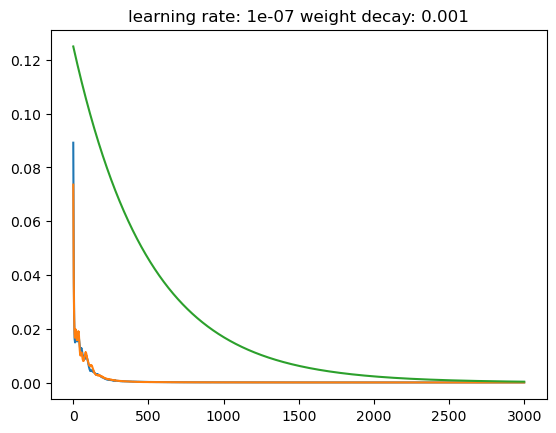

In [94]:
# lr = 1e-7
# wd = 1e-3
# model = Network()
# epochs = 1000
# optimizer = torch.optim.Adam(
#         model.parameters(),
#         lr           = lr,
#         weight_decay = wd,
#     )

# gamma = 0.997
# scheduler = lr_scheduler.ExponentialLR(
#     optimizer, 
#     #step_size = scheduler_step_size, 
#     gamma     = gamma)

txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/8e-7 for lr in lrs ])
plt.show()

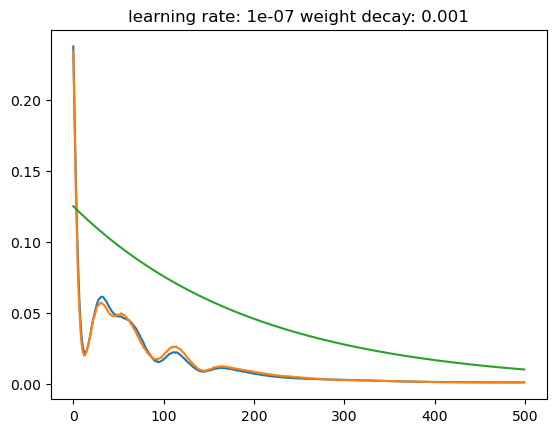

In [78]:
txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/8e-7 for lr in lrs ])
plt.show()

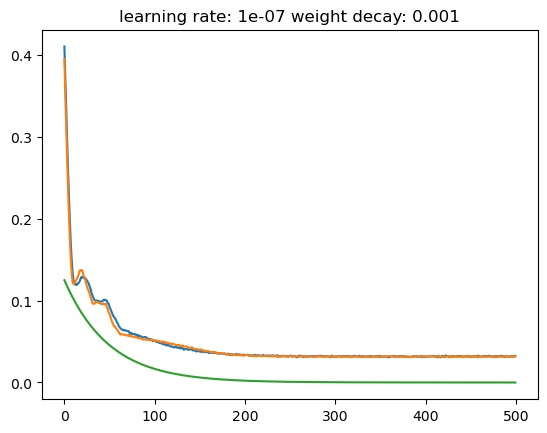

In [66]:
txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/8e-7 for lr in lrs ])
plt.show()

# Cyclic learning rates

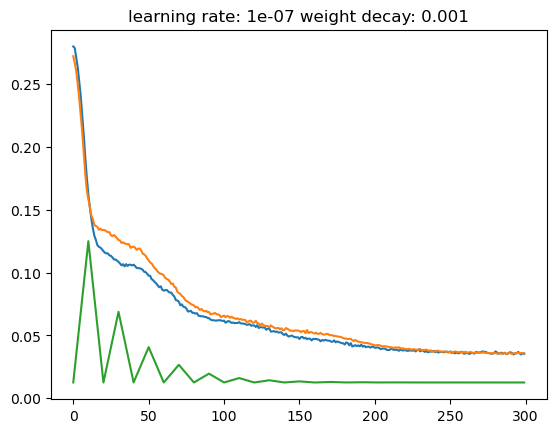

In [44]:
# lr = 1e-7
# wd = 1e-3
# model = Network()

# epochs = 500
# optimizer = torch.optim.Adam(
#         model.parameters(),
#         lr           = lr,
#         weight_decay = wd,
#     )

# # scheduler = lr_scheduler.CyclicLR(
# #     optimizer,
# #     base_lr=1e-8,
# #     max_lr=1e-7,
# #     cycle_momentum=False,
# #     gamma=1,
# #     step_size_up=10,
# #     step_size_down =10,
# #     mode='triangular2',
# #)

# gamma = 0.995
# scheduler = lr_scheduler.ExponentialLR(
#     optimizer, 
#     #step_size = scheduler_step_size, 
#     gamma     = gamma)

# train_losses = []
# val_losses   = []
# lrs          = []


txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/8e-7 for lr in lrs ])
plt.show()

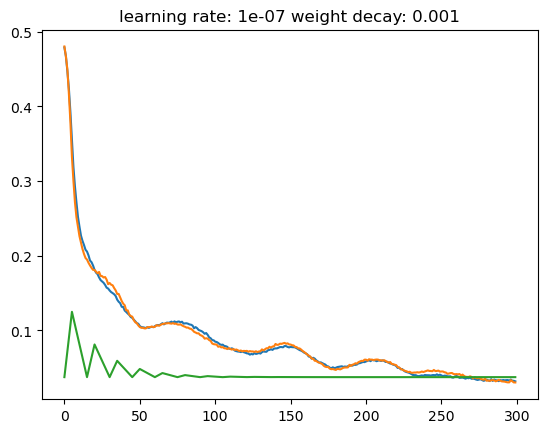

In [36]:
txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/8e-7 for lr in lrs ])
plt.show()

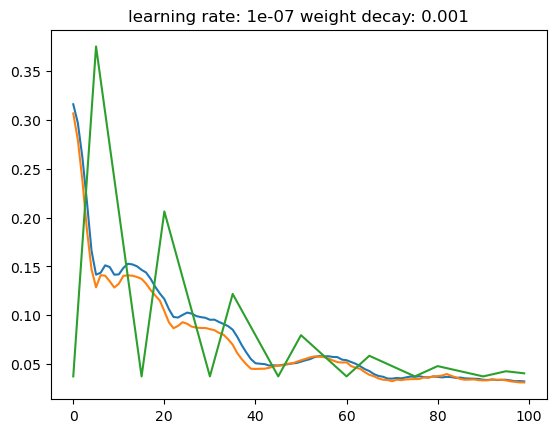

In [29]:
txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/8e-7 for lr in lrs ])
plt.show()

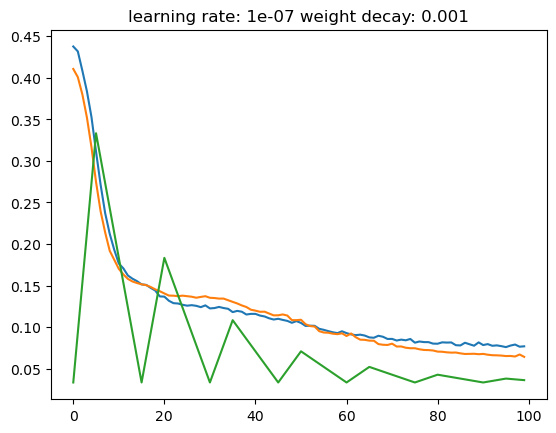

In [23]:
txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/3e-7 for lr in lrs ])
plt.show()

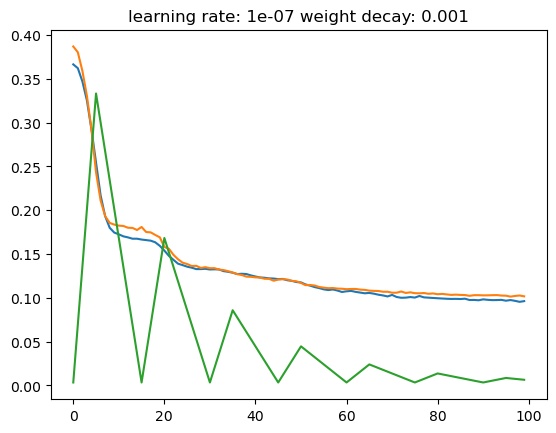

In [21]:
txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/3e-7 for lr in lrs ])
plt.show()

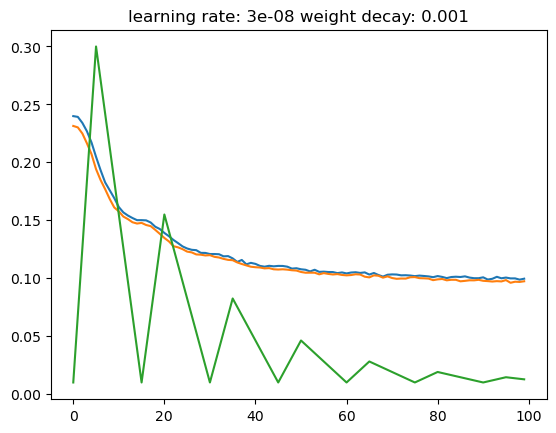

In [37]:
txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/1e-7 for lr in lrs ])
plt.show()


0.6506117749925988


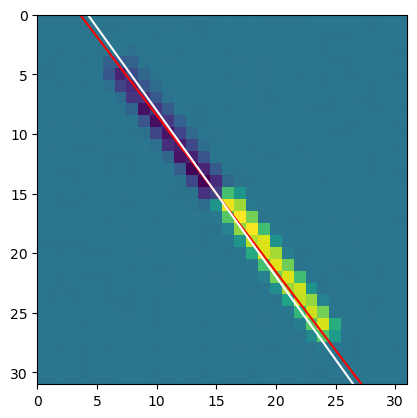

1.9078102869505287


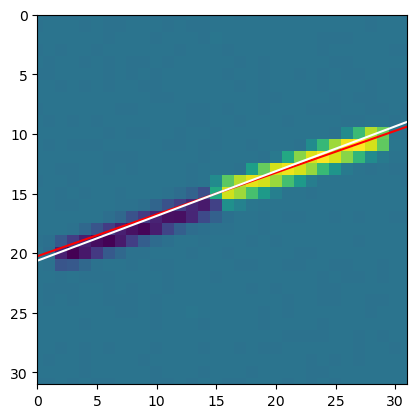

2.7130688152396276


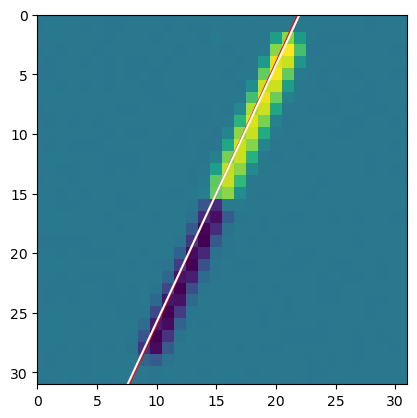

1.9078102869505287


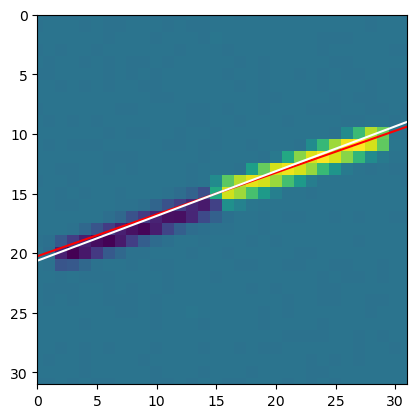

0.06456256607248266


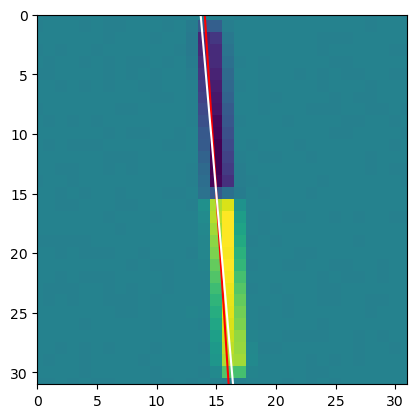

2.2226928626604443


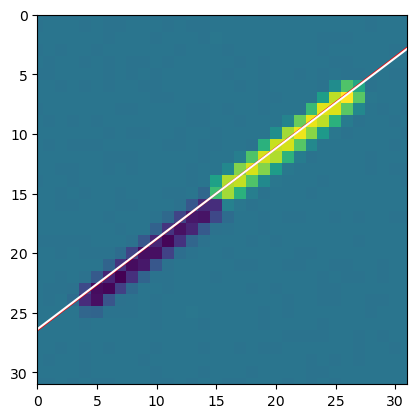

2.185236527649239


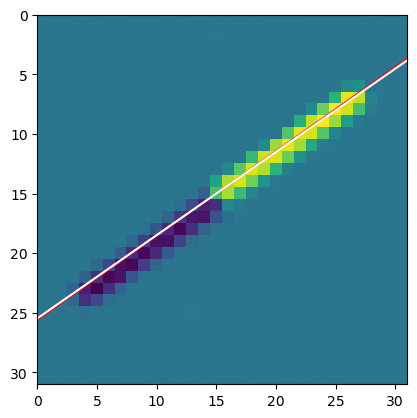

1.6348276845050844


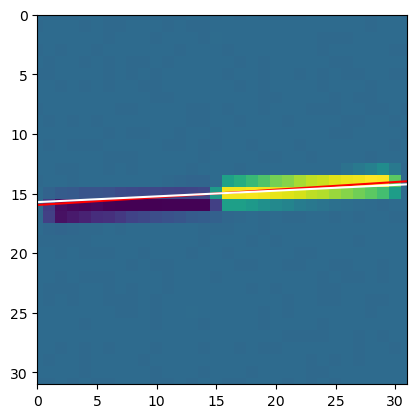

0.8952774631906669


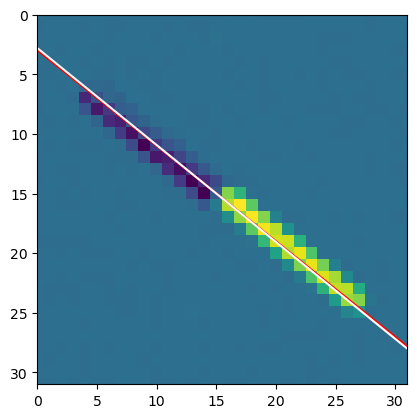

0.6764847327499335


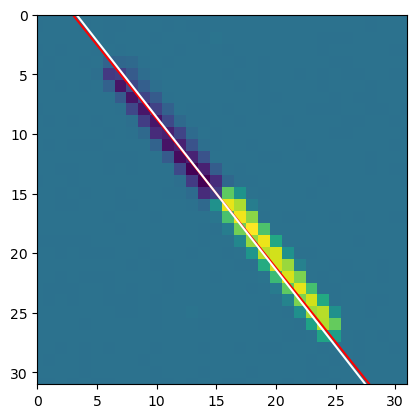

2.9697429411943492


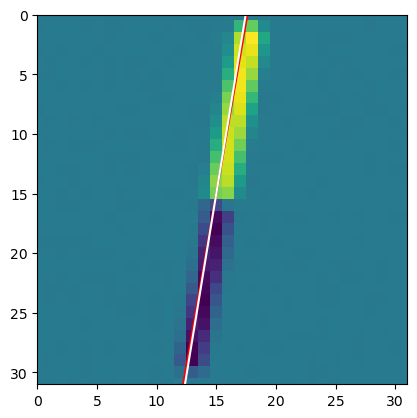

0.9340542432422784


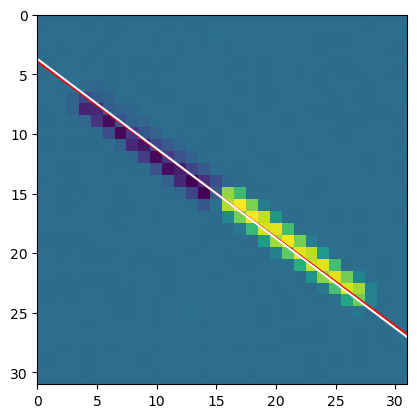

2.499889578088799


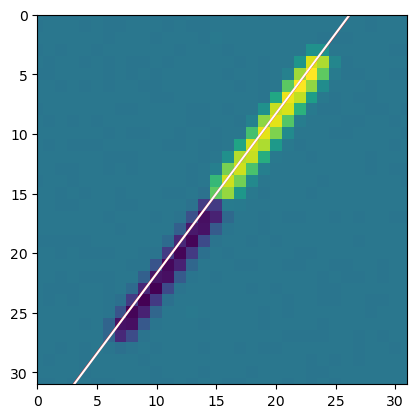

1.9367913628781288


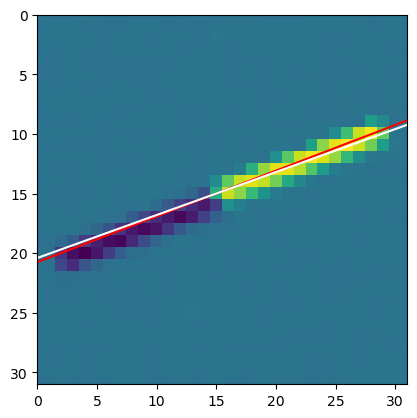

1.2504772392432075


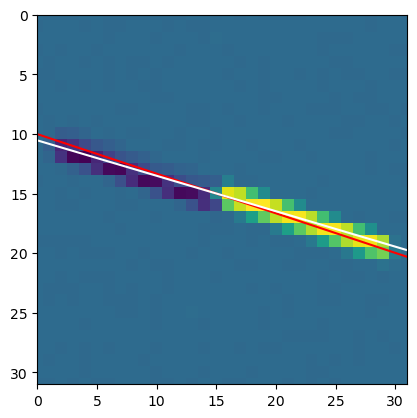

1.1148951552085853


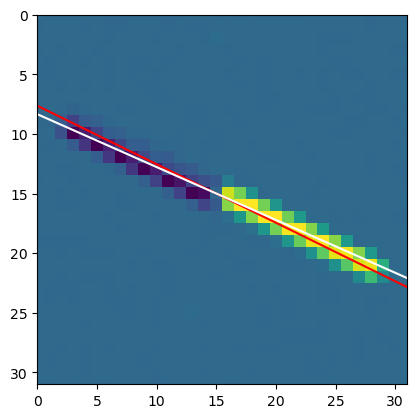

2.5445058778501872


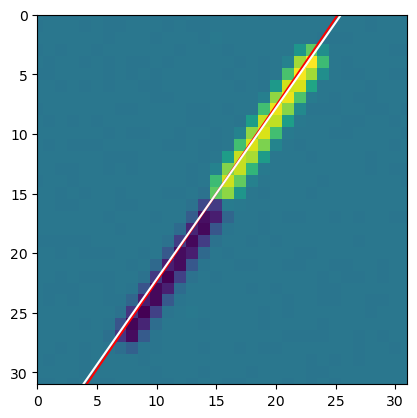

2.3532128371739427


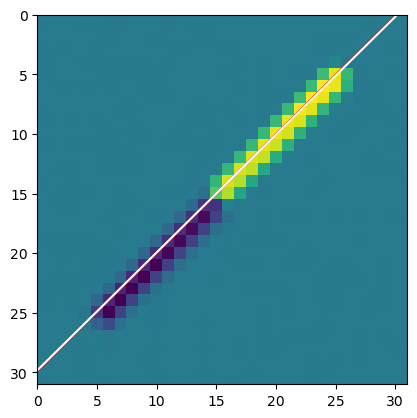

0.26603518309847524


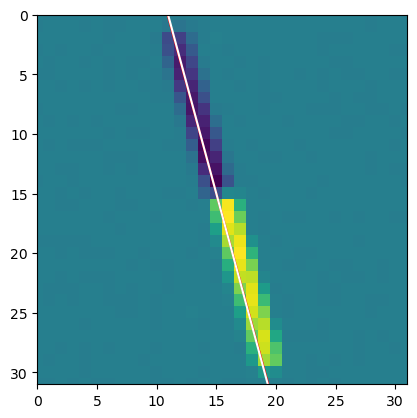

0.3614214179429713


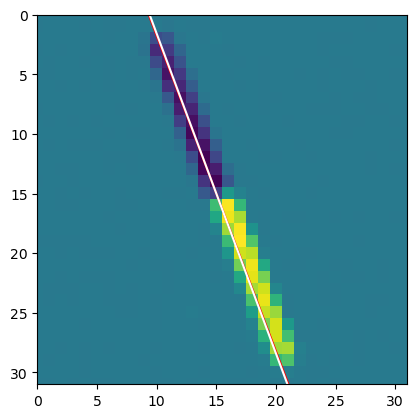

2.08335928490726


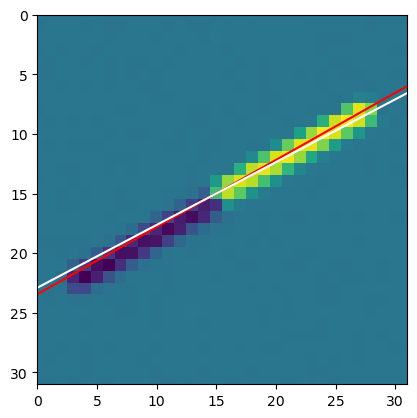

0.7640868768198804


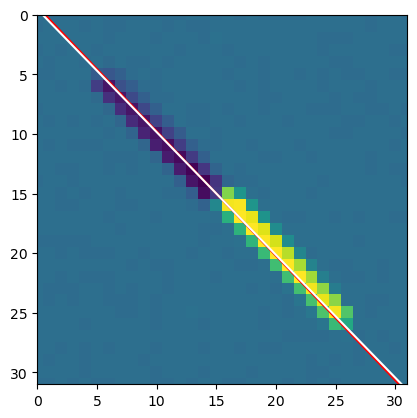

0.1728858207733261


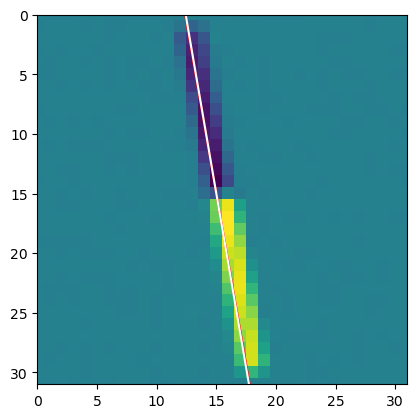

1.1892691895374206


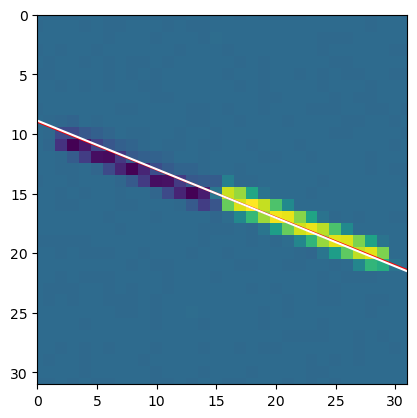

0.7727172526752375


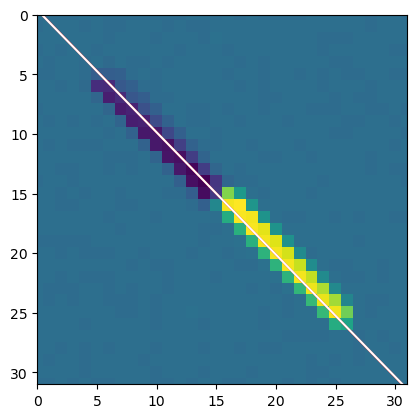

1.8229490531142887


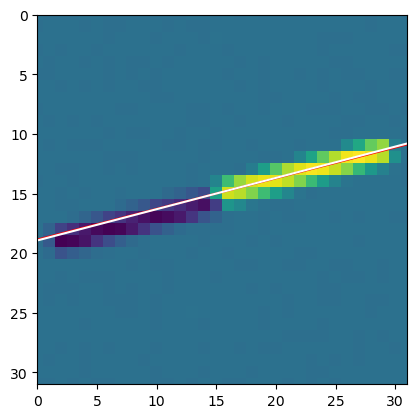

1.6780937169303924


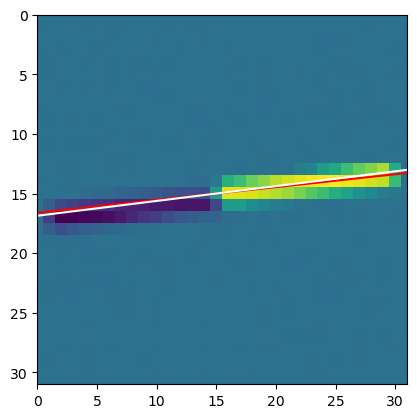

0.4229408347381896


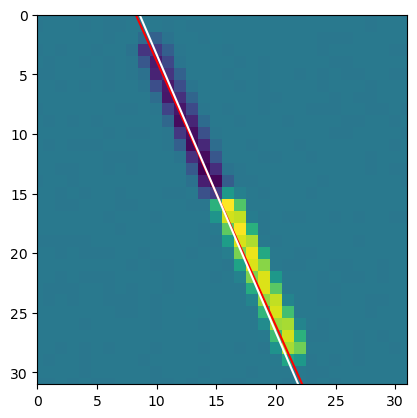

0.8291575703546284


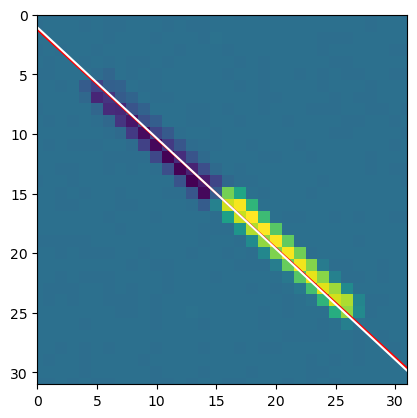

1.7468345803874354


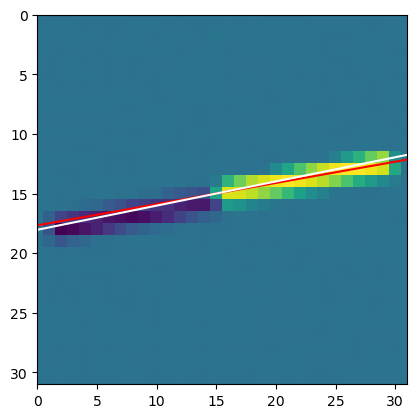

In [95]:
test_IDs = [ random.randint(0,999) for i in range(100) ]

real = []
outputs = []
for ID in test_IDs[:30]:
    input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
    label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
    
    X = torchvision.io.read_image(
                input_dir + str(ID) + ".png "
            ).to(torch.float32)
    plt.imshow(X[1])
    X = X/256.
    
    with open(label_dir + str(ID), 'rb') as fb:
        Y  = pickle.load(fb)
        Y = Y[1][0]#/3.1415926
        
    #Y = Y + 0.5
        
    output = (float(model(X[1].unsqueeze(0).unsqueeze(0))) + 0.5 )*3.1415926
    print(Y)
    
    real.append(Y)
    outputs.append(output)
    
    #plt.plot( [16 - 50*math.tan(Y),16 ,16 + 50*math.tan(Y)],[16 - 50, 16,16 + 50], c='r')
    plt.plot( [15 - 50*math.tan(Y),15 ,15 + 50*math.tan(Y)],[15 - 50, 15,15 + 50], c='r')
    plt.plot( [15 - 50*math.tan(output),15 ,15 + 50*math.tan(output)],[15 - 50, 15,15 + 50], c='w')
    
    plt.xlim(0,31)
    plt.ylim(31,0)
    
    #plt.axvline( x = (Y + 1)*16, c='w' )
    #plt.axvline( x = (output + 1.)*16, c='r')
    plt.show()
    
        

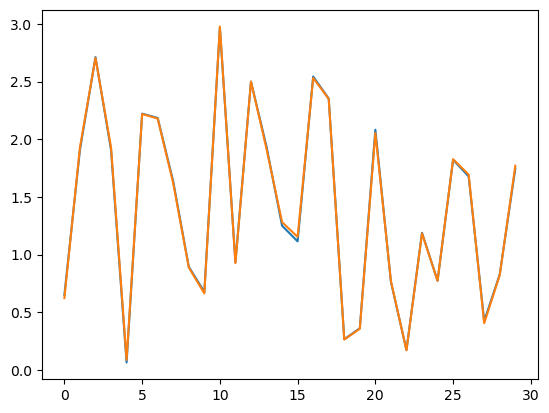

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Anaconda\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Anaconda\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Anaconda\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Anaconda\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelector

In [96]:
plt.plot(real)
plt.plot(outputs)

In [91]:
lr = 1e-7
wd = 1e-3
model = Network()

epochs = 3000
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd,
    )

# scheduler = lr_scheduler.CyclicLR(
#     optimizer,
#     base_lr=1e-8,
#     max_lr=1e-7,
#     cycle_momentum=False,
#     gamma=1,
#     step_size_up=10,
#     step_size_down =10,
#     mode='triangular2',
# )
gamma = 0.998
scheduler = lr_scheduler.ExponentialLR(
    optimizer, 
    #step_size = scheduler_step_size, 
    gamma     = gamma)

scheduler

train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    optimizer.step()
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()

# txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
# plt.title(txt)
# plt.plot(train_losses)
# plt.plot(val_losses)
# plt.show()

# for batch in validation_generator:
#     break
# output = model(batch[0])
# output
# plt.title(txt)
# plt.plot(output.detach().numpy()*3.1415926)
# plt.plot(batch[1].detach().numpy()*3.1415926)
# plt.show()

2.468842135385987e-10

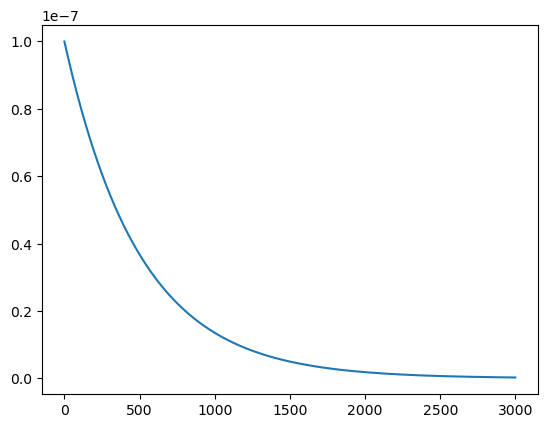

In [92]:
plt.plot(lrs)
min(lrs)

1.7475207219249251


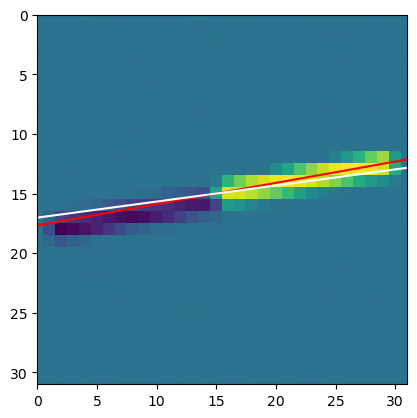

3.1290161616188743


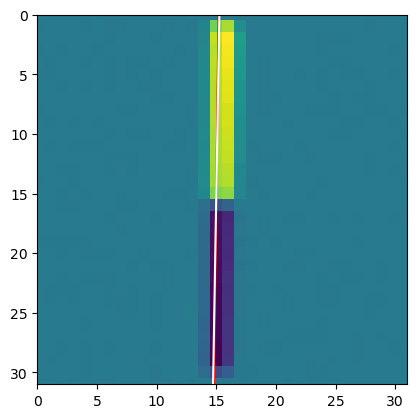

0.6025142452573792


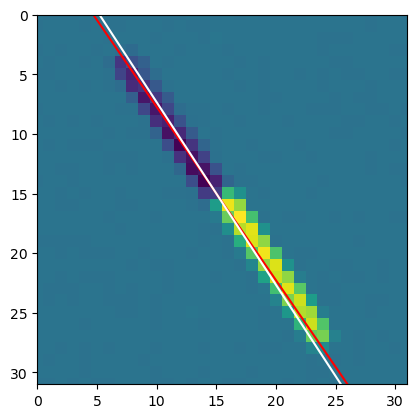

2.308952630130757


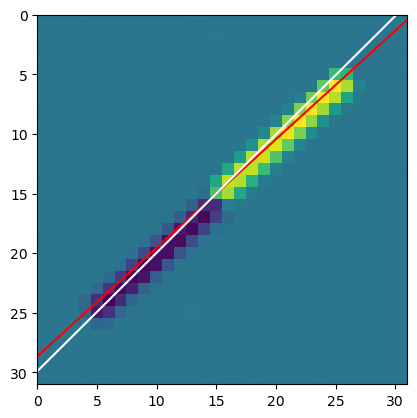

1.1091131755045982


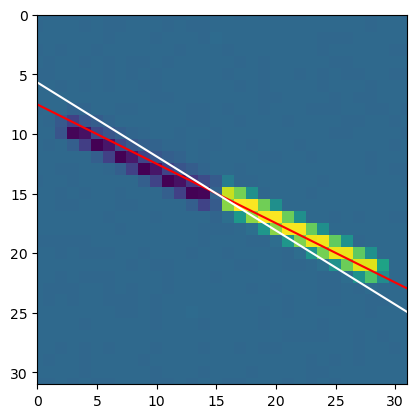

0.7732709527235844


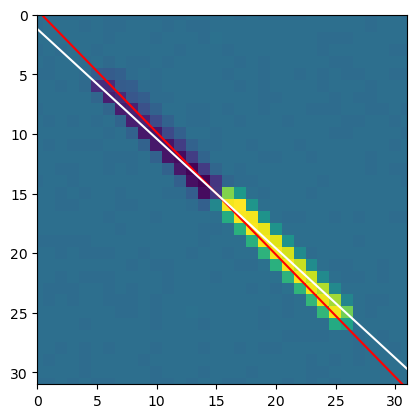

2.4535876757229507


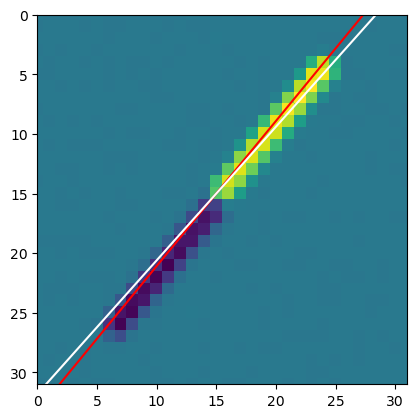

1.2613899028541484


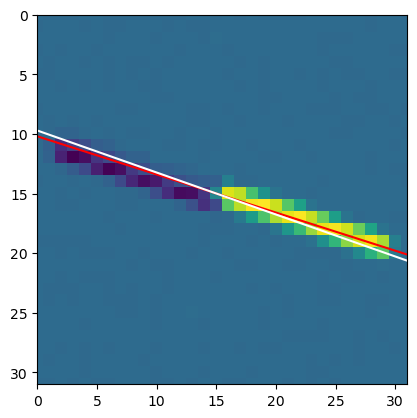

1.1073010224431923


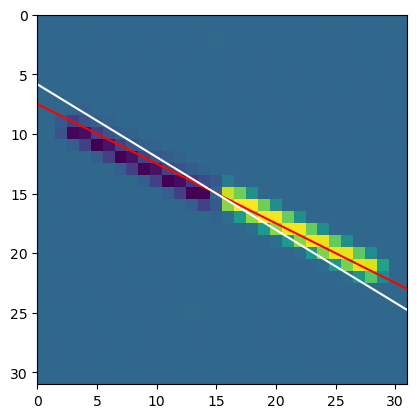

0.3956274044061136


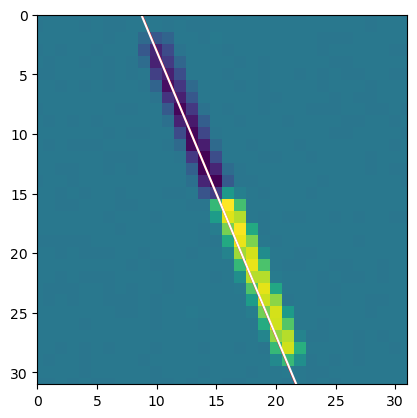

2.8434310128751896


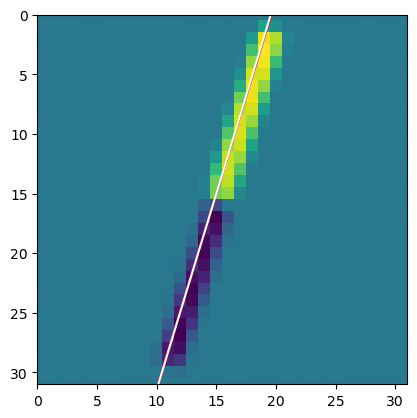

2.9152868708747035


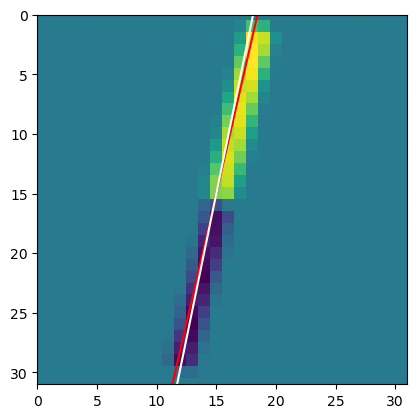

1.0687974994127918


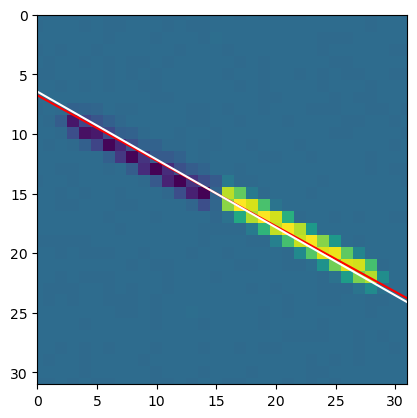

1.926067131985782


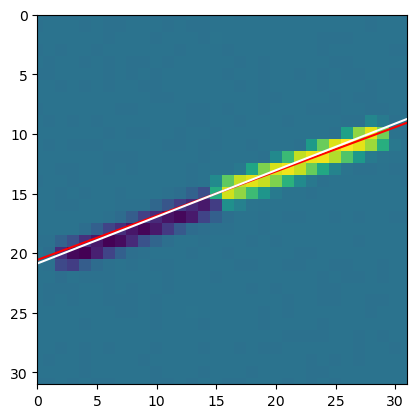

0.6194797188967616


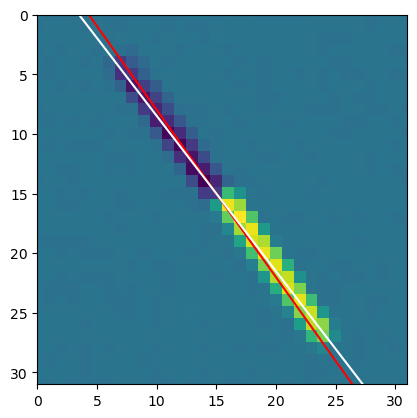

0.6469769271391902


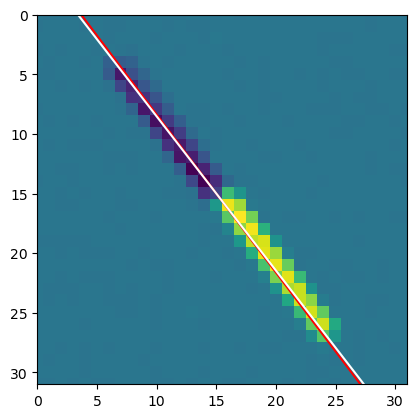

0.7281788792066887


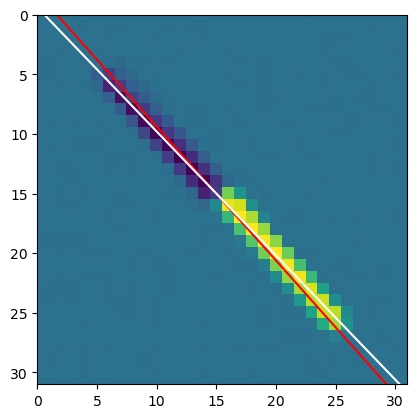

2.7130688152396276


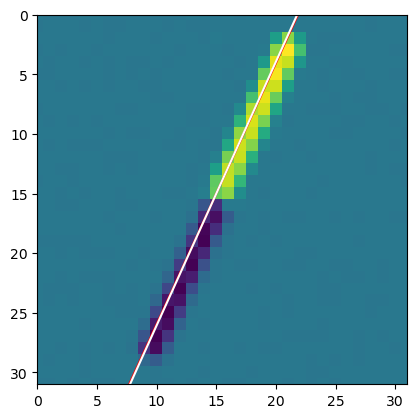

2.4110951587110594


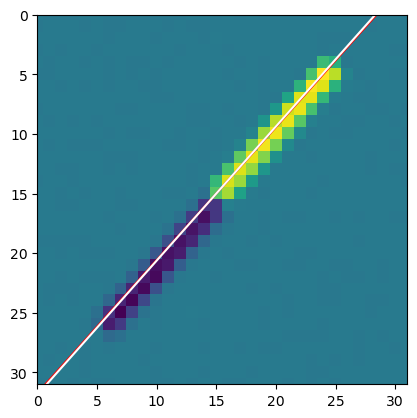

2.699003331773767


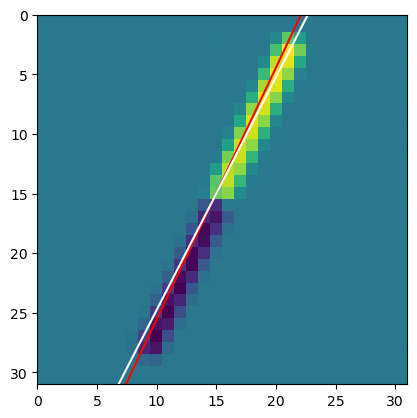

2.1514229092261554


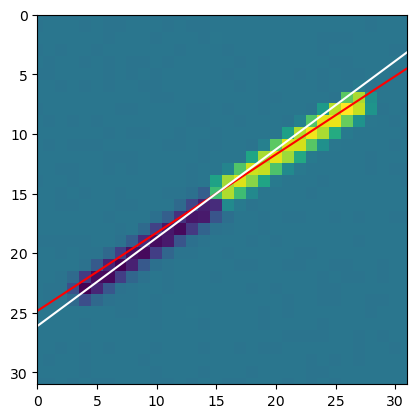

2.0106961793722493


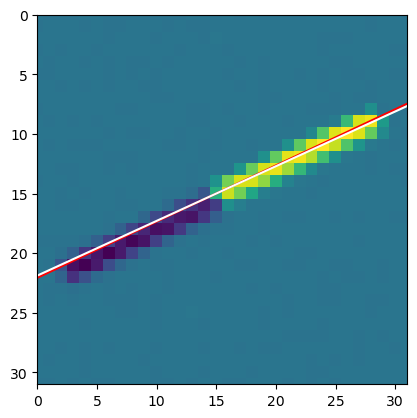

1.6348276845050844


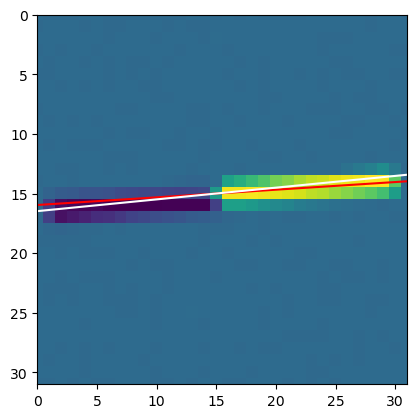

1.0267967757918302


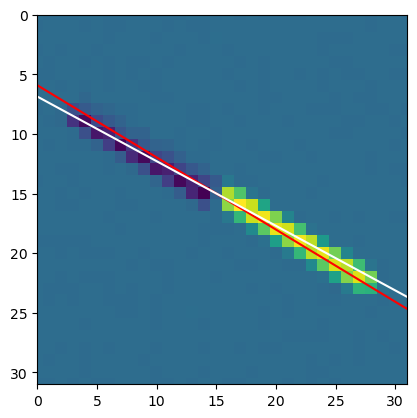

2.24891992511053


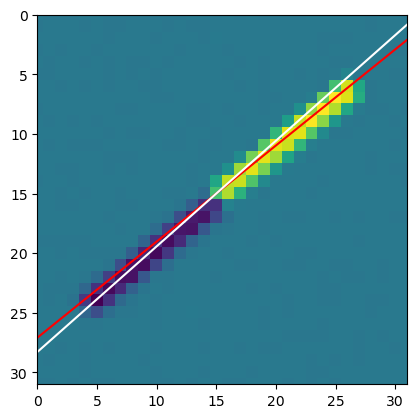

1.8848297072326143


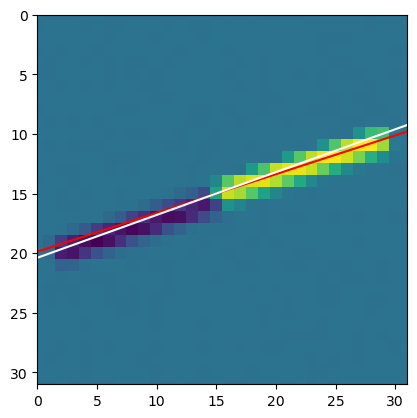

2.397992566599654


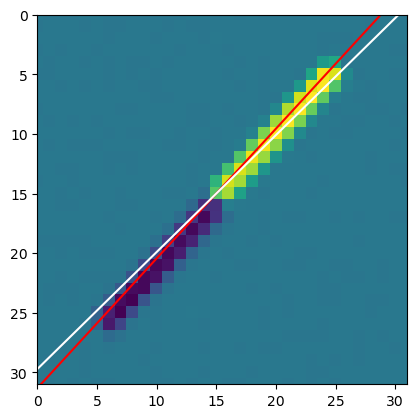

3.0539918340406125


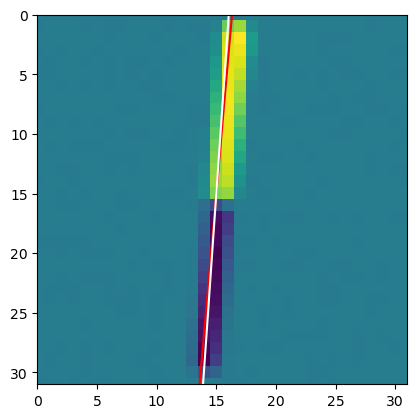

2.295010699515085


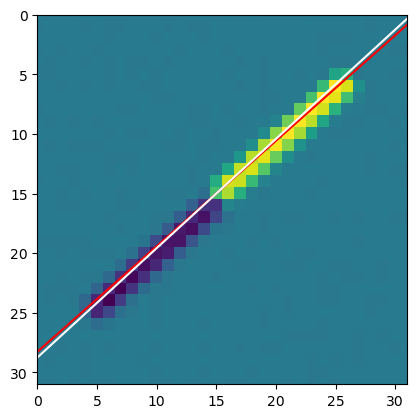

3.0925109476500303


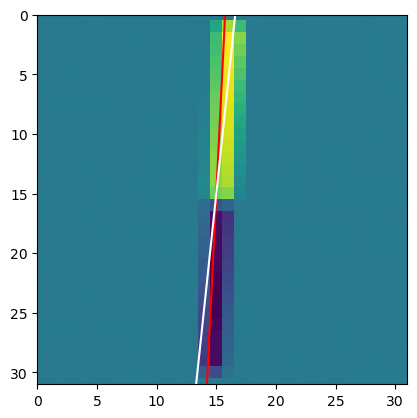

In [87]:
test_IDs = [ random.randint(0,999) for i in range(100) ]

real = []
outputs = []
for ID in test_IDs[:30]:
    input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
    label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
    
    X = torchvision.io.read_image(
                input_dir + str(ID) + ".png "
            ).to(torch.float32)
    plt.imshow(X[1])
    X = X/256.
    
    with open(label_dir + str(ID), 'rb') as fb:
        Y  = pickle.load(fb)
        Y = Y[1][0]#/3.1415926
        
    #Y = Y + 0.5
        
    output = (float(model(X[1].unsqueeze(0).unsqueeze(0))) + 0.5 )*3.1415926
    print(Y)
    
    real.append(Y)
    outputs.append(output)
    
    #plt.plot( [16 - 50*math.tan(Y),16 ,16 + 50*math.tan(Y)],[16 - 50, 16,16 + 50], c='r')
    plt.plot( [15 - 50*math.tan(Y),15 ,15 + 50*math.tan(Y)],[15 - 50, 15,15 + 50], c='r')
    plt.plot( [15 - 50*math.tan(output),15 ,15 + 50*math.tan(output)],[15 - 50, 15,15 + 50], c='w')
    
    plt.xlim(0,31)
    plt.ylim(31,0)
    
    #plt.axvline( x = (Y + 1)*16, c='w' )
    #plt.axvline( x = (output + 1.)*16, c='r')
    plt.show()
    
        

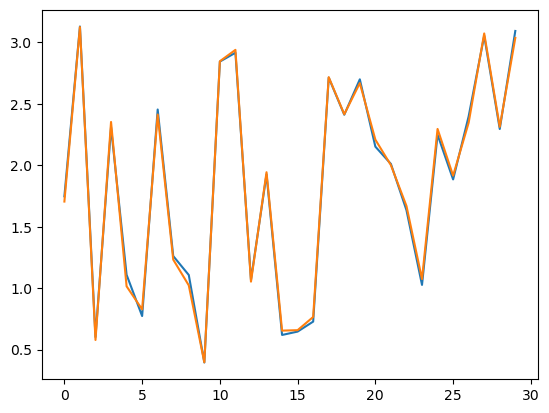

In [88]:
plt.plot(real)
plt.plot(outputs)